### XGBoost PIPELINE

In [1]:
import joblib
from datetime import datetime
import numpy as np
import os
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

from backend.ml_pipe.data.database.mongodb import MongoDb
from backend.ml_pipe.models.xgboost.model import XGBoostModel

In [2]:
from backend.ml_pipe.data.database.mongodb import MongoDb
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
from collections import defaultdict

# 1. Lade das Position-Mapping
with open("/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/xgboost/saved_models/position_categories.pkl", "rb") as f:
    position_categories = pickle.load(f)
position_mapping = {name: idx for idx, name in enumerate(position_categories, 1)}

# 2. Branchen-Mapping
branche_levels = {
    "bau": 1,
    "consulting": 2,
    "customerservice": 3,
    "design": 4,
    "education": 5,
    "einkauf": 6,
    "engineering": 7,
    "finance": 8,
    "freelance": 9,
    "gesundheit": 10,
    "healthcare": 11,
    "hr": 12,
    "immobilien": 13,
    "it": 14,
    "legal": 15,
    "logistik": 16,
    "marketing": 17,
    "medien": 18,
    "operations": 19,
    "produktion": 20,
    "projektmanagement": 21,
    "research": 22,
    "sales": 23,
    "verwaltung": 24
}

def load_and_filter_labels_from_mongodb(
    user="florianrunkel",
    password="ur04mathesis",
    db_name="Database",
    collection="classification_dataset",
    show_plot=True
):
    mongo_client = MongoDb(user=user, password=password, db_name=db_name)
    result = mongo_client.get_all(collection)
    raw_data = result.get('data', [])
    df = pd.DataFrame(raw_data)
    return df

def extract_career_history_features(career_history, branche_levels, position_mapping):
    durations = [pos.get("duration", 0) for pos in career_history.values()]
    avg_duration = sum(durations) / len(durations) if durations else 0

    branches = [pos.get("branche", "") for pos in career_history.values()]
    branche_changes = sum(1 for i in range(1, len(branches)) if branches[i] != branches[i-1])
    num_unique_branches = len(set(branches))

    positions = [pos.get("position", "") for pos in career_history.values()]
    position_changes = sum(1 for i in range(1, len(positions)) if positions[i] != positions[i-1])
    num_unique_positions = len(set(positions))

    branche_days = defaultdict(int)
    for pos in career_history.values():
        branche_days[pos.get("branche", "")] += pos.get("duration", 0)
    top_branche_days = sorted(branche_days.items(), key=lambda x: x[1], reverse=True)[:3]
    branche1_days = top_branche_days[0][1] if len(top_branche_days) > 0 else 0
    branche2_days = top_branche_days[1][1] if len(top_branche_days) > 1 else 0
    branche3_days = top_branche_days[2][1] if len(top_branche_days) > 2 else 0

    max_level = max([pos.get("level", 0) for pos in career_history.values()] or [0])

    # Optional: weitere Features, z.B. durchschnittlicher Level, etc.

    # Optional: Die letzten N Positionen als numerische Features (hier N=3)
    last_positions = list(career_history.values())
    last_positions_features = []
    for pos in last_positions:
        last_positions_features.append(pos.get("duration", 0))
        last_positions_features.append(branche_levels.get(pos.get("branche", ""), 0))
        last_positions_features.append(pos.get("level", 0))
        last_positions_features.append(position_mapping.get(pos.get("position", ""), 0))

    return [
        avg_duration,
        branche_changes,
        position_changes,
        num_unique_branches,
        num_unique_positions,
        branche1_days,
        branche2_days,
        branche3_days,
        max_level
    ]

def extract_xgb_features(features_dict):
    """
    Extrahiert flache Features aus dem Feature-Dictionary für XGBoost.
    Gibt eine Liste von numerischen Features zurück.
    """
    feature_list = [
        features_dict.get("company_changes", 0),
        features_dict.get("total_experience_days", 0),
        features_dict.get("location_changes", 0),
        position_mapping.get(features_dict.get("position", ""), 0),
        features_dict.get("highest_degree", 0),
        features_dict.get("position_level", 0),
        branche_levels.get(features_dict.get("position_branche", ""), 0),
        features_dict.get("position_duration", 0),
        features_dict.get("age_category", 0)
    ]

    feature_list.extend(
        extract_career_history_features(
            features_dict.get("career_history", {}),
            branche_levels,
            position_mapping
        )
    )
    print(feature_list)
    return feature_list


df = load_and_filter_labels_from_mongodb()
feature_array = [extract_xgb_features(features) for features in df["features"]]

[3, 2129, 1, 0, 3, 2, 7, 1156, 2, 324.3333333333333, 2, 2, 3, 3, 700, 152, 121, 2]
[3, 1645, 1, 0, 3, 2, 7, 672, 2, 324.3333333333333, 2, 2, 3, 3, 700, 152, 121, 2]
[2, 973, 1, 0, 3, 1, 8, 121, 2, 426.0, 1, 1, 2, 2, 700, 152, 0, 2]
[2, 869, 1, 0, 3, 1, 8, 17, 2, 426.0, 1, 1, 2, 2, 700, 152, 0, 2]
[1, 852, 1, 0, 3, 1, 17, 152, 2, 700.0, 0, 0, 1, 1, 700, 0, 0, 2]
[1, 741, 1, 0, 3, 1, 17, 41, 2, 700.0, 0, 0, 1, 1, 700, 0, 0, 2]
[0, 700, 0, 0, 3, 2, 7, 700, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 639, 0, 0, 3, 2, 7, 639, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 3499, 1, 0, 1, 6, 11, 213, 4, 1095.3333333333333, 2, 2, 2, 3, 2252, 1034, 0, 7]
[2, 3426, 1, 0, 1, 6, 11, 140, 4, 1095.3333333333333, 2, 2, 2, 3, 2252, 1034, 0, 7]
[2, 3286, 1, 0, 1, 2, 17, 2039, 4, 623.5, 1, 1, 2, 2, 1034, 213, 0, 7]
[2, 3169, 1, 0, 1, 2, 17, 1922, 4, 623.5, 1, 1, 2, 2, 1034, 213, 0, 7]
[1, 1247, 0, 0, 1, 7, 23, 1034, 4, 213.0, 0, 0, 1, 1, 213, 0, 0, 4]
[1, 745, 0, 0, 1, 7, 23, 532, 4, 213.0, 0, 0, 1, 1, 213, 0, 0, 4]
[0, 213, 

Starte XGBoost-Pipeline...
[3, 2129, 1, 0, 3, 2, 7, 1156, 2, 324.3333333333333, 2, 2, 3, 3, 700, 152, 121, 2]
[3, 1645, 1, 0, 3, 2, 7, 672, 2, 324.3333333333333, 2, 2, 3, 3, 700, 152, 121, 2]
[2, 973, 1, 0, 3, 1, 8, 121, 2, 426.0, 1, 1, 2, 2, 700, 152, 0, 2]
[2, 869, 1, 0, 3, 1, 8, 17, 2, 426.0, 1, 1, 2, 2, 700, 152, 0, 2]
[1, 852, 1, 0, 3, 1, 17, 152, 2, 700.0, 0, 0, 1, 1, 700, 0, 0, 2]
[1, 741, 1, 0, 3, 1, 17, 41, 2, 700.0, 0, 0, 1, 1, 700, 0, 0, 2]
[0, 700, 0, 0, 3, 2, 7, 700, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 639, 0, 0, 3, 2, 7, 639, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 3499, 1, 0, 1, 6, 11, 213, 4, 1095.3333333333333, 2, 2, 2, 3, 2252, 1034, 0, 7]
[2, 3426, 1, 0, 1, 6, 11, 140, 4, 1095.3333333333333, 2, 2, 2, 3, 2252, 1034, 0, 7]
[2, 3286, 1, 0, 1, 2, 17, 2039, 4, 623.5, 1, 1, 2, 2, 1034, 213, 0, 7]
[2, 3169, 1, 0, 1, 2, 17, 1922, 4, 623.5, 1, 1, 2, 2, 1034, 213, 0, 7]
[1, 1247, 0, 0, 1, 7, 23, 1034, 4, 213.0, 0, 0, 1, 1, 213, 0, 0, 4]
[1, 745, 0, 0, 1, 7, 23, 532, 4, 213.0, 0, 0, 1,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:32] WARN

[CV] END colsample_bytree=0.749816047538945, gamma=4.75357153204958, grow_policy=depthwise, learning_rate=0.15693820005455386, max_delta_step=4, max_depth=10, max_leaves=92, min_child_weight=11, n_estimators=658, reg_alpha=4.330880728874676, reg_lambda=6.011150117432088, sampling_method=gradient_based, subsample=0.8603553891795411, tree_method=hist; total time=   0.1s
[CV] END colsample_bytree=0.749816047538945, gamma=4.75357153204958, grow_policy=depthwise, learning_rate=0.15693820005455386, max_delta_step=4, max_depth=10, max_leaves=92, min_child_weight=11, n_estimators=658, reg_alpha=4.330880728874676, reg_lambda=6.011150117432088, sampling_method=gradient_based, subsample=0.8603553891795411, tree_method=hist; total time=   0.0s
[CV] END colsample_bytree=0.749816047538945, gamma=4.75357153204958, grow_policy=depthwise, learning_rate=0.15693820005455386, max_delta_step=4, max_depth=10, max_leaves=92, min_child_weight=11, n_estimators=658, reg_alpha=4.330880728874676, reg_lambda=6.011

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARN

[CV] END colsample_bytree=0.6225646316108401, gamma=3.609993861334124, grow_policy=lossguide, learning_rate=0.04346782213565523, max_delta_step=4, max_depth=4, max_leaves=85, min_child_weight=12, n_estimators=760, reg_alpha=2.6238733012919457, reg_lambda=3.9986097171525548, sampling_method=gradient_based, subsample=0.7168578594140873, tree_method=hist; total time=   0.1s
[CV] END colsample_bytree=0.6225646316108401, gamma=3.609993861334124, grow_policy=lossguide, learning_rate=0.04346782213565523, max_delta_step=4, max_depth=4, max_leaves=85, min_child_weight=12, n_estimators=760, reg_alpha=2.6238733012919457, reg_lambda=3.9986097171525548, sampling_method=gradient_based, subsample=0.7168578594140873, tree_method=hist; total time=   0.0s
[CV] END colsample_bytree=0.6225646316108401, gamma=3.609993861334124, grow_policy=lossguide, learning_rate=0.04346782213565523, max_delta_step=4, max_depth=4, max_leaves=85, min_child_weight=12, n_estimators=760, reg_alpha=2.6238733012919457, reg_lamb

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9768807022739411, gamma=2.8164410892276965, grow_policy=lossguide, learning_rate=0.06192275383467414, max_delta_step=4, max_depth=5, max_leaves=93, min_child_weight=15, n_estimators=654, reg_alpha=3.0499832889131047, reg_lambda=8.331949117361644, sampling_method=uniform, subsample=0.9637281608315128, tree_method=hist; total time=   0.6s
[CV] END colsample_bytree=0.9768807022739411, gamma=2.8164410892276965, grow_policy=lossguide, learning_rate=0.06192275383467414, max_delta_step=4, max_depth=5, max_leaves=93, min_child_weight=15, n_estimators=654, reg_alpha=3.0499832889131047, reg_lambda=8.331949117361644, sampling_method=uniform, subsample=0.9637281608315128, tree_method=hist; total time=   0.7s
[CV] END colsample_bytree=0.8170784332632994, gamma=0.7046211248738132, grow_policy=depthwise, learning_rate=0.0340533878126005, max_delta_step=8, max_depth=10, max_leaves=18, min_child_weight=1, n_estimators=671, reg_alpha=0.07039911357542228, reg_lambda=1.98842404

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARN

[CV] END colsample_bytree=0.8170784332632994, gamma=0.7046211248738132, grow_policy=depthwise, learning_rate=0.0340533878126005, max_delta_step=8, max_depth=10, max_leaves=18, min_child_weight=1, n_estimators=671, reg_alpha=0.07039911357542228, reg_lambda=1.9884240408880516, sampling_method=gradient_based, subsample=0.8916028672163949, tree_method=hist; total time=   0.0s
[CV] END colsample_bytree=0.9085081386743783, gamma=0.3702232586704518, grow_policy=depthwise, learning_rate=0.1312154051003889, max_delta_step=6, max_depth=4, max_leaves=81, min_child_weight=12, n_estimators=232, reg_alpha=0.3177917514301182, reg_lambda=3.109823217156622, sampling_method=gradient_based, subsample=0.8663689426469987, tree_method=hist; total time=   0.0s
[CV] END colsample_bytree=0.9085081386743783, gamma=0.3702232586704518, grow_policy=depthwise, learning_rate=0.1312154051003889, max_delta_step=6, max_depth=4, max_leaves=81, min_child_weight=12, n_estimators=232, reg_alpha=0.3177917514301182, reg_lamb

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:33] WARN

[CV] END colsample_bytree=0.7306163075223342, gamma=2.852219872026997, grow_policy=lossguide, learning_rate=0.010045457782107612, max_delta_step=7, max_depth=8, max_leaves=89, min_child_weight=13, n_estimators=537, reg_alpha=2.698460661945399, reg_lambda=5.867511656638483, sampling_method=uniform, subsample=0.7123738038749523, tree_method=hist; total time=   1.1s
[CV] END colsample_bytree=0.7306163075223342, gamma=2.852219872026997, grow_policy=lossguide, learning_rate=0.010045457782107612, max_delta_step=7, max_depth=8, max_leaves=89, min_child_weight=13, n_estimators=537, reg_alpha=2.698460661945399, reg_lambda=5.867511656638483, sampling_method=uniform, subsample=0.7123738038749523, tree_method=hist; total time=   1.2s
[CV] END colsample_bytree=0.9771414282231924, gamma=2.99432733244268, grow_policy=depthwise, learning_rate=0.03324425745080089, max_delta_step=1, max_depth=5, max_leaves=54, min_child_weight=6, n_estimators=227, reg_alpha=1.092202186084168, reg_lambda=4.16509947870366

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9771414282231924, gamma=2.99432733244268, grow_policy=depthwise, learning_rate=0.03324425745080089, max_delta_step=1, max_depth=5, max_leaves=54, min_child_weight=6, n_estimators=227, reg_alpha=1.092202186084168, reg_lambda=4.165099478703662, sampling_method=gradient_based, subsample=0.8157368967662603, tree_method=hist; total time=   0.1s
[CV] END colsample_bytree=0.9771414282231924, gamma=2.99432733244268, grow_policy=depthwise, learning_rate=0.03324425745080089, max_delta_step=1, max_depth=5, max_leaves=54, min_child_weight=6, n_estimators=227, reg_alpha=1.092202186084168, reg_lambda=4.165099478703662, sampling_method=gradient_based, subsample=0.8157368967662603, tree_method=hist; total time=   0.1s
[CV] END colsample_bytree=0.8769744131561081, gamma=1.3470616689926074, grow_policy=lossguide, learning_rate=0.18958194078250384, max_delta_step=5, max_depth=11, max_leaves=105, min_child_weight=9, n_estimators=312, reg_alpha=0.3244612355449078, reg_lambda=2.5

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARN

[CV] END colsample_bytree=0.8769744131561081, gamma=1.3470616689926074, grow_policy=lossguide, learning_rate=0.18958194078250384, max_delta_step=5, max_depth=11, max_leaves=105, min_child_weight=9, n_estimators=312, reg_alpha=0.3244612355449078, reg_lambda=2.539154139343447, sampling_method=gradient_based, subsample=0.7007129183301457, tree_method=hist; total time=   0.0s
[CV] END colsample_bytree=0.7306163075223342, gamma=2.852219872026997, grow_policy=lossguide, learning_rate=0.010045457782107612, max_delta_step=7, max_depth=8, max_leaves=89, min_child_weight=13, n_estimators=537, reg_alpha=2.698460661945399, reg_lambda=5.867511656638483, sampling_method=uniform, subsample=0.7123738038749523, tree_method=hist; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.922976062065625, gamma=4.480456499617466, grow_policy=depthwise, learning_rate=0.18236568830915081, max_delta_step=0, max_depth=4, max_leaves=36, min_child_weight=13, n_estimators=458, reg_alpha=0.03476065265595352, reg_lambda=5.107473025775658, sampling_method=uniform, subsample=0.7939319885435933, tree_method=hist; total time=   0.4s
[CV] END colsample_bytree=0.8842651558743149, gamma=0.5544541040591566, grow_policy=lossguide, learning_rate=0.022578285398660893, max_delta_step=6, max_depth=4, max_leaves=61, min_child_weight=4, n_estimators=684, reg_alpha=1.2464611457443748, reg_lambda=4.103829230356297, sampling_method=uniform, subsample=0.6812244898939077, tree_method=hist; total time=   1.1s
[CV] END colsample_bytree=0.922976062065625, gamma=4.480456499617466, grow_policy=depthwise, learning_rate=0.18236568830915081, max_delta_step=0, max_depth=4, max_leaves=36, min_child_weight=13, n_estimators=458, reg_alpha=0.03476065265595352, reg_lambda=5.1074730257

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARN

[CV] END colsample_bytree=0.7988994023569542, gamma=1.5043915490838482, grow_policy=depthwise, learning_rate=0.20054809700978837, max_delta_step=0, max_depth=5, max_leaves=11, min_child_weight=5, n_estimators=424, reg_alpha=3.171756723506819, reg_lambda=6.807054515547668, sampling_method=uniform, subsample=0.7957811041110252, tree_method=hist; total time=   0.5s
[CV] END colsample_bytree=0.7988994023569542, gamma=1.5043915490838482, grow_policy=depthwise, learning_rate=0.20054809700978837, max_delta_step=0, max_depth=5, max_leaves=11, min_child_weight=5, n_estimators=424, reg_alpha=3.171756723506819, reg_lambda=6.807054515547668, sampling_method=uniform, subsample=0.7957811041110252, tree_method=hist; total time=   0.5s
[CV] END colsample_bytree=0.8842651558743149, gamma=0.5544541040591566, grow_policy=lossguide, learning_rate=0.022578285398660893, max_delta_step=6, max_depth=4, max_leaves=61, min_child_weight=4, n_estimators=684, reg_alpha=1.2464611457443748, reg_lambda=4.103829230356

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6697465716019966, gamma=3.45468869051233, grow_policy=lossguide, learning_rate=0.10455027010549603, max_delta_step=7, max_depth=4, max_leaves=20, min_child_weight=18, n_estimators=350, reg_alpha=2.707239869137829, reg_lambda=6.957843993450822, sampling_method=uniform, subsample=0.8639936184136716, tree_method=hist; total time=   0.4s
[CV] END colsample_bytree=0.7988994023569542, gamma=1.5043915490838482, grow_policy=depthwise, learning_rate=0.20054809700978837, max_delta_step=0, max_depth=5, max_leaves=11, min_child_weight=5, n_estimators=424, reg_alpha=3.171756723506819, reg_lambda=6.807054515547668, sampling_method=uniform, subsample=0.7957811041110252, tree_method=hist; total time=   0.5s
[CV] END colsample_bytree=0.6697465716019966, gamma=3.45468869051233, grow_policy=lossguide, learning_rate=0.10455027010549603, max_delta_step=7, max_depth=4, max_leaves=20, min_child_weight=18, n_estimators=350, reg_alpha=2.707239869137829, reg_lambda=6.957843993450822,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARN

[CV] END colsample_bytree=0.9268888800804863, gamma=2.7760040579973118, grow_policy=lossguide, learning_rate=0.05316583496608181, max_delta_step=0, max_depth=11, max_leaves=21, min_child_weight=5, n_estimators=236, reg_alpha=4.413181715946698, reg_lambda=1.8870710834137938, sampling_method=uniform, subsample=0.7396838298450643, tree_method=hist; total time=   0.4s
[CV] END colsample_bytree=0.9268888800804863, gamma=2.7760040579973118, grow_policy=lossguide, learning_rate=0.05316583496608181, max_delta_step=0, max_depth=11, max_leaves=21, min_child_weight=5, n_estimators=236, reg_alpha=4.413181715946698, reg_lambda=1.8870710834137938, sampling_method=uniform, subsample=0.7396838298450643, tree_method=hist; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8903822715480958, gamma=4.485551299762886, grow_policy=lossguide, learning_rate=0.08190162542443802, max_delta_step=0, max_depth=11, max_leaves=125, min_child_weight=11, n_estimators=619, reg_alpha=4.492770942635397, reg_lambda=6.0642905965958995, sampling_method=uniform, subsample=0.7489131066246972, tree_method=hist; total time=   0.6s
[CV] END colsample_bytree=0.8903822715480958, gamma=4.485551299762886, grow_policy=lossguide, learning_rate=0.08190162542443802, max_delta_step=0, max_depth=11, max_leaves=125, min_child_weight=11, n_estimators=619, reg_alpha=4.492770942635397, reg_lambda=6.0642905965958995, sampling_method=uniform, subsample=0.7489131066246972, tree_method=hist; total time=   0.7s
[CV] END colsample_bytree=0.9179245214166594, gamma=2.5131854655259604, grow_policy=lossguide, learning_rate=0.13478481193261993, max_delta_step=0, max_depth=8, max_leaves=70, min_child_weight=16, n_estimators=715, reg_alpha=0.1215798321572692, reg_lambda=6.454722

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARN

[CV] END colsample_bytree=0.7879778055963772, gamma=1.3978017089837929, grow_policy=lossguide, learning_rate=0.07503174005108888, max_delta_step=8, max_depth=8, max_leaves=33, min_child_weight=17, n_estimators=501, reg_alpha=4.833274095218348, reg_lambda=9.636199770892528, sampling_method=uniform, subsample=0.6301385024024513, tree_method=hist; total time=   1.0s
[CV] END colsample_bytree=0.7222788077148727, gamma=0.9545551557517301, grow_policy=depthwise, learning_rate=0.06438440103125553, max_delta_step=1, max_depth=4, max_leaves=115, min_child_weight=3, n_estimators=487, reg_alpha=3.355717584120253, reg_lambda=3.586467812961639, sampling_method=uniform, subsample=0.8073318609454947, tree_method=hist; total time=   0.6s
[CV] END colsample_bytree=0.7222788077148727, gamma=0.9545551557517301, grow_policy=depthwise, learning_rate=0.06438440103125553, max_delta_step=1, max_depth=4, max_leaves=115, min_child_weight=3, n_estimators=487, reg_alpha=3.355717584120253, reg_lambda=3.58646781296

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:36] WARN

[CV] END colsample_bytree=0.6020739451095947, gamma=3.13947207474318, grow_policy=lossguide, learning_rate=0.13099278615555304, max_delta_step=2, max_depth=10, max_leaves=24, min_child_weight=2, n_estimators=250, reg_alpha=2.3279900906623006, reg_lambda=5.426446347075766, sampling_method=uniform, subsample=0.9355734008277453, tree_method=hist; total time=   0.3s
[CV] END colsample_bytree=0.7879778055963772, gamma=1.3978017089837929, grow_policy=lossguide, learning_rate=0.07503174005108888, max_delta_step=8, max_depth=8, max_leaves=33, min_child_weight=17, n_estimators=501, reg_alpha=4.833274095218348, reg_lambda=9.636199770892528, sampling_method=uniform, subsample=0.6301385024024513, tree_method=hist; total time=   1.0s
[CV] END colsample_bytree=0.6020739451095947, gamma=3.13947207474318, grow_policy=lossguide, learning_rate=0.13099278615555304, max_delta_step=2, max_depth=10, max_leaves=24, min_child_weight=2, n_estimators=250, reg_alpha=2.3279900906623006, reg_lambda=5.4264463470757

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARN

[CV] END colsample_bytree=0.6020739451095947, gamma=3.13947207474318, grow_policy=lossguide, learning_rate=0.13099278615555304, max_delta_step=2, max_depth=10, max_leaves=24, min_child_weight=2, n_estimators=250, reg_alpha=2.3279900906623006, reg_lambda=5.426446347075766, sampling_method=uniform, subsample=0.9355734008277453, tree_method=hist; total time=   0.4s
[CV] END colsample_bytree=0.9509492287711822, gamma=3.703843088771022, grow_policy=depthwise, learning_rate=0.028324266288405765, max_delta_step=5, max_depth=11, max_leaves=48, min_child_weight=10, n_estimators=737, reg_alpha=4.050566973395904, reg_lambda=8.670723185801037, sampling_method=uniform, subsample=0.6326376721600961, tree_method=hist; total time=   1.0s
[CV] END colsample_bytree=0.9509492287711822, gamma=3.703843088771022, grow_policy=depthwise, learning_rate=0.028324266288405765, max_delta_step=5, max_depth=11, max_leaves=48, min_child_weight=10, n_estimators=737, reg_alpha=4.050566973395904, reg_lambda=8.6707231858

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARN

[CV] END colsample_bytree=0.7083329005048297, gamma=2.1948571035281805, grow_policy=depthwise, learning_rate=0.05117210546933224, max_delta_step=9, max_depth=8, max_leaves=71, min_child_weight=9, n_estimators=257, reg_alpha=4.576068638132402, reg_lambda=4.423522297311044, sampling_method=gradient_based, subsample=0.8196906658824482, tree_method=hist; total time=   0.0s
[CV] END colsample_bytree=0.9441618473246701, gamma=1.2512568025793203, grow_policy=lossguide, learning_rate=0.16552011213193166, max_delta_step=5, max_depth=6, max_leaves=69, min_child_weight=5, n_estimators=463, reg_alpha=3.849967765493054, reg_lambda=2.1582102749684315, sampling_method=uniform, subsample=0.7829060646454914, tree_method=hist; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9441618473246701, gamma=1.2512568025793203, grow_policy=lossguide, learning_rate=0.16552011213193166, max_delta_step=5, max_depth=6, max_leaves=69, min_child_weight=5, n_estimators=463, reg_alpha=3.849967765493054, reg_lambda=2.1582102749684315, sampling_method=uniform, subsample=0.7829060646454914, tree_method=hist; total time=   0.6s
[CV] END colsample_bytree=0.9441618473246701, gamma=1.2512568025793203, grow_policy=lossguide, learning_rate=0.16552011213193166, max_delta_step=5, max_depth=6, max_leaves=69, min_child_weight=5, n_estimators=463, reg_alpha=3.849967765493054, reg_lambda=2.1582102749684315, sampling_method=uniform, subsample=0.7829060646454914, tree_method=hist; total time=   0.7s
[CV] END colsample_bytree=0.9509492287711822, gamma=3.703843088771022, grow_policy=depthwise, learning_rate=0.028324266288405765, max_delta_step=5, max_depth=11, max_leaves=48, min_child_weight=10, n_estimators=737, reg_alpha=4.050566973395904, reg_lambda=8.6707231858

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9368092300047925, gamma=0.9719001699743651, grow_policy=lossguide, learning_rate=0.10912702432202132, max_delta_step=6, max_depth=11, max_leaves=61, min_child_weight=16, n_estimators=468, reg_alpha=4.847684335570795, reg_lambda=7.1459510417995205, sampling_method=uniform, subsample=0.9180744779074814, tree_method=hist; total time=   0.7s
[CV] END colsample_bytree=0.9368092300047925, gamma=0.9719001699743651, grow_policy=lossguide, learning_rate=0.10912702432202132, max_delta_step=6, max_depth=11, max_leaves=61, min_child_weight=16, n_estimators=468, reg_alpha=4.847684335570795, reg_lambda=7.1459510417995205, sampling_method=uniform, subsample=0.9180744779074814, tree_method=hist; total time=   0.7s
[CV] END colsample_bytree=0.8858383690800249, gamma=3.3009868835886564, grow_policy=depthwise, learning_rate=0.12865411876867008, max_delta_step=6, max_depth=11, max_leaves=72, min_child_weight=5, n_estimators=446, reg_alpha=0.23858063845824395, reg_lambda=5.66037

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
36 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12


Beste Parameter: {'colsample_bytree': 0.7465447373174767, 'gamma': 2.28034992108518, 'grow_policy': 'depthwise', 'learning_rate': 0.12467720186661746, 'max_delta_step': 6, 'max_depth': 7, 'max_leaves': 73, 'min_child_weight': 3, 'n_estimators': 684, 'reg_alpha': 3.0377242595071916, 'reg_lambda': 1.7052412368729153, 'sampling_method': 'uniform', 'subsample': 0.6053059844639466, 'tree_method': 'hist'}
Bester F1-Score : 0.9122793482360554
Beste Parameter (Randomized Search): {'colsample_bytree': 0.7465447373174767, 'gamma': 2.28034992108518, 'grow_policy': 'depthwise', 'learning_rate': 0.12467720186661746, 'max_delta_step': 6, 'max_depth': 7, 'max_leaves': 73, 'min_child_weight': 3, 'n_estimators': 684, 'reg_alpha': 3.0377242595071916, 'reg_lambda': 1.7052412368729153, 'sampling_method': 'uniform', 'subsample': 0.6053059844639466, 'tree_method': 'hist'} Score: None
Nehme Randomized Search Parameter!
[INFO] Training XGBoost model...
[INFO] Training completed.
Evaluationsergebnisse:
Accura

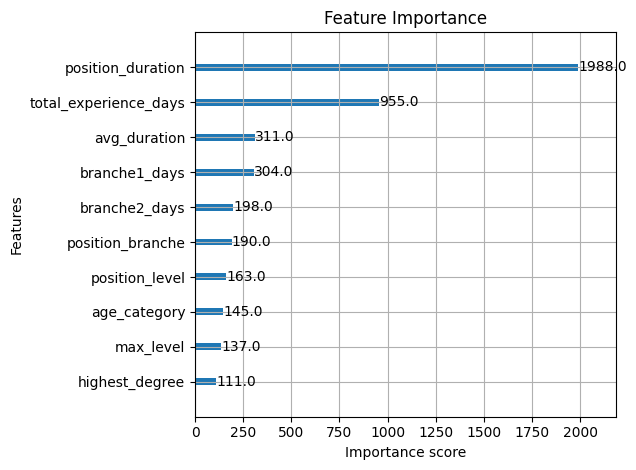

In [3]:
def run_xgboost_pipeline():
    print("Starte XGBoost-Pipeline...")

    df = load_and_filter_labels_from_mongodb()
    #print(df.head())
    feature_array = [extract_xgb_features(features) for features in df["features"]]
    X = pd.DataFrame(feature_array, columns=[
        "company_changes",
        "total_experience_days",
        "location_changes",
        "position",
        "highest_degree",
        "position_level",
        "position_branche",
        "position_duration",
        "age_category",
        "avg_duration",
        "branche_changes",
        "position_changes",
        "num_unique_branches",
        "num_unique_positions",
        "branche1_days",
        "branche2_days",
        "branche3_days",
        "max_level"
    ])
    #print(X.head())

    X["position"] = X["position"].astype("category")
    y = df["label"]

    print(X.head())

    # 3. Train/Test-Split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    print(f"Trainingsdaten: {X_train.shape}, Validierungsdaten: {X_val.shape}")

    # 4. Modell trainieren
    model = XGBoostModel()

    # Randomized Search
    best_params_random = model.randomized_search(X_train, y_train)
    score_random = model.model.best_score if hasattr(model.model, 'best_score') else None

    print("Beste Parameter (Randomized Search):", best_params_random, "Score:", score_random)


    best_params = best_params_random
    print("Nehme Randomized Search Parameter!")

    model.train(X_train, y_train)
    # 5. Modell evaluieren
    f1 = model.evaluate(X_val, y_val)

    # 6. Modell speichern mit Timestamp
    position_categories = list(X["position"].cat.categories)
    import joblib
    joblib.dump(position_categories, "/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/xgboost/saved_models/position_categories.pkl")
    print("Position-Kategorien gespeichert!")

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = "saved_models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"xgboost_model_{timestamp}.joblib")
    joblib.dump(model.model, model_path)
    print(f"Modell gespeichert unter: {model_path}")

    # 7. Optional: Feature Importance anzeigen
    try:
        model.plot_feature_importance()
    except Exception as e:
        print(f"Fehler beim Plotten der Feature-Wichtigkeit: {e}")

if __name__ == "__main__":
    run_xgboost_pipeline()

In [1]:
import sys
import json
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')

from backend.ml_pipe.models.xgboost.predict import predict

# LinkedIn Profildaten als Raw-String (beachte das 'r' vor dem String)
linkedin_data_str = r'''{"skills":["Multitasking","Kundenservice","Interpersonelle Fähigkeiten","Kaltakquise","Hubspot CRM","Customer-Relationship-Management (CRM)"],"firstName":"Darya","lastName":"Chernuska","profilePicture":"https://media.licdn.com/dms/image/v2/D4E03AQE0yuZ6cg8f4A/profile-displayphoto-shrink_100_100/profile-displayphoto-shrink_100_100/0/1670856025914?e=1749686400&v=beta&t=jI1mkiVnkD7teWPncsg8QtKAwZKB-az53_4ny7C7XvI","linkedinProfile":"https://www.linkedin.com/in/daryachernuska","education":[{"duration":"01/01/2017 - 01/01/2022","institution":"Ludwig-Maximilians-Universität München","endDate":"01/01/2022","degree":"","startDate":"01/01/2017"}],"providerId":"ACoAAD0rz_IBI0XfqqBDUscwHoFwuOqJa_c5T2I","workExperience":[{"duration":"01/03/2023 - Present","endDate":"Present","companyInformation":{"employee_count":515,"activities":["Telefonie","Internet","Vernetzung","Rechenzentrum","Glasfaser","Highspeed-Internet","Business-Internet","SIP-Trunk","Cloud-Lösungen","Connect-Cloud","Connect-LAN","Premium IP","Internet + Telefonie","Lösungen für Geschäftskunden"],"name":"M-net Telekommunikations GmbH","description":"Als regionaler Telekommunikationsanbieter versorgt M-net große Teile Bayerns, den Großraum Ulm sowie weite Teile des hessischen Landkreises Main-Kinzig mit zukunftssicherer Kommunikationstechnologie.","industry":["Telecommunications"]},"description":"","company":"M-net Telekommunikations GmbH","location":"München, Bayern, Deutschland · Hybrid","position":"Disponentin","startDate":"01/03/2023"},{"duration":"01/08/2022 - 01/12/2022","endDate":"01/12/2022","companyInformation":{"employee_count":2048,"activities":["HR Software","HR Management","Recruitung","Employee Management","Applicant Tracking System","Employee Selfservice","Time-Off Management","Cloud Software","Onboarding and Offboarding","HR Reporting","Performance Management","Payroll","HR","HR Tech","Human Resources"],"name":"Personio","description":"Personio's Intelligent HR Platform helps small and medium-sized organizations unlock the power of people by making complicated, time-consuming tasks simple and efficient.","industry":["Software Development"]},"description":"","company":"Personio","location":"München, Bayern, Deutschland","position":"Sales Development Representative","startDate":"01/08/2022"},{"duration":"01/11/2017 - 01/07/2022","endDate":"01/07/2022","companyInformation":{"employee_count":662,"activities":["Scandinavian design","Furniture","Design","Product design","Retail","Web","Steelcase partner","Wholesale","B2B","Contract sales","Online","Digital","Creativity"],"name":"BOLIA","description":"Our collection is inspired by the vivid Scandinavian nature","industry":["Retail Furniture and Home Furnishings"]},"description":"","company":"Bolia.com","location":"München, Bayern, Deutschland","position":"Sales Consultant","startDate":"01/11/2017"},{"duration":"01/10/2015 - 01/11/2017","endDate":"01/11/2017","companyInformation":{},"description":"","company":"Pepperminds","location":"München, Bayern, Deutschland","position":"Senior Team Lead","startDate":"01/10/2015"}],"location":"Munich, Bavaria, Germany","certifications":[],"headline":"-","languageSkills":{}}'''

try:
    # JSON-String in Dictionary umwandeln
    profile_data = json.loads(linkedin_data_str)
    
    # Vorhersage machen
    result = predict(profile_data)
    print("\nVorhersageergebnis:")
    print(f"Tage bis zum Wechsel: {result['confidence']}")
    print(f"Status: {result['status']}")
    print("\nEmpfehlungen:")
    for rec in result['recommendations']:
        print(f"- {rec}")
    
    # SHAP-Erklärungen anzeigen
    print("\n" + "="*60)
    print("SHAP FEATURE-ERKLÄRUNGEN:")
    print("="*60)
    if 'shap_explanations' in result and result['shap_explanations']:
        for exp in result['shap_explanations']:
            print(f"- {exp['feature']}: {exp['impact_percentage']:.1f}% - {exp['description']}")
    else:
        print("Keine SHAP-Erklärungen verfügbar")
    
    # LIME-Erklärungen anzeigen
    print("\n" + "="*60)
    print("LIME FEATURE-ERKLÄRUNGEN:")
    print("="*60)
    if 'lime_explanations' in result and result['lime_explanations']:
        for exp in result['lime_explanations']:
            print(f"- {exp['feature']}: {exp['impact_percentage']:.1f}% - {exp['description']}")
    else:
        print("Keine LIME-Erklärungen verfügbar")
        
except json.JSONDecodeError as e:
    print(f"JSON Fehler: {str(e)}")
    print(f"Fehler an Position: {e.pos}")
    print(f"Zeile: {e.lineno}, Spalte: {e.colno}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


Fehler bei SHAP-Berechnung: <class 'xgboost.sklearn.XGBClassifier'> is not currently a supported model type!
Fehler bei Standard LIME-Berechnung: 'numpy.ndarray' object has no attribute 'numpy'

Vorhersageergebnis:
Status: very likely to change
Konfidenz: 78.64%

Empfehlungen:
- The candidate is very likely to change.
- Change probability: 78.6%

Feature-Wichtigkeiten:


KeyError: 'explanations'